# fmdtools Tutorial

This tutorial notebook will show some of the basic commands needed to perform resilience analysis in fmdtools.

For some context, it may be helpful to look through the accompanying presentation. This notebook uses the model defined in `ex_pump.py`. In this notebook, we will:

- Load an environment and model
- Simulate the system in nominal and faulty scenarios
- Visualize and quantify the results

## 1.) Loading the environment and model

To load the `fmdtools` environment, we have to install and import it. This can be accomplished using `pip` for both the stable and development versions:

In [1]:
##Stable (PyPl) version
# pip install fmdtools

##Development version (downloaded from git)
# pip install -e /path/to/fmdtools ##Note that /path/to/fmdtools is the path to the fmdtools repo

There are a number of different syntaxes for importing modules. Because of the long names of the module trees, it is often helpful to load the modules individually and abbreviate (e.g. ``import fmdtools.sim.propagate as propagate``). Below, import the propagate `fmdtools.sim.propagate` and `fmdtools.analyze` modules, as well as sampling using the `fmdtools.sim.sample` module.

In [2]:
import fmdtools.sim.propagate as propagate
from fmdtools.sim.sample import FaultDomain, FaultSample
from fmdtools.analyze.phases import PhaseMap
import fmdtools.analyze as an

Now, import the Pump class defined in the ex_pump module.

In [3]:
from ex_pump import Pump

We can then use that to instantiate a model object. See:

In [4]:
mdl = Pump()

To get started, it can be helpful to view some of the aspects of the model. Try `dir(mdl)`, `mdl.fxns`, `mdl.flows`, `mdl.graph`, etc.

In [5]:
mdl.fxns

{'import_ee': import_ee ImportEE
 - ImportEEState(effstate=1.0)
 - ImportEEMode(mode=nominal, faults=set()),
 'import_water': import_water ImportWater
 - ImportWaterMode(mode=nominal, faults=set()),
 'import_signal': import_signal ImportSig
 - ImportSigMode(mode=nominal, faults=set()),
 'move_water': move_water MoveWat
 - MoveWatStates(eff=1.0)
 - MoveWatMode(mode=nominal, faults=set()),
 'export_water': export_water ExportWater
 - ExportWaterMode(mode=nominal, faults=set())}

We can also view the run order to see how the model will be simulated. More details on run order are provided in [Model Structure Visualization Tutorial](../docs/Model_Structure_Visualization_Tutorial.ipynb), but in short static propagation functions simulate multiple times per time-step until the model converges, while dynamic propagation functions run once per timestep in a defined order.

In [6]:
mg = an.graph.FunctionArchitectureGraph(mdl)

In [7]:
mg.set_exec_order(mdl)

(<Figure size 1200x1000 with 1 Axes>, <Axes: >)

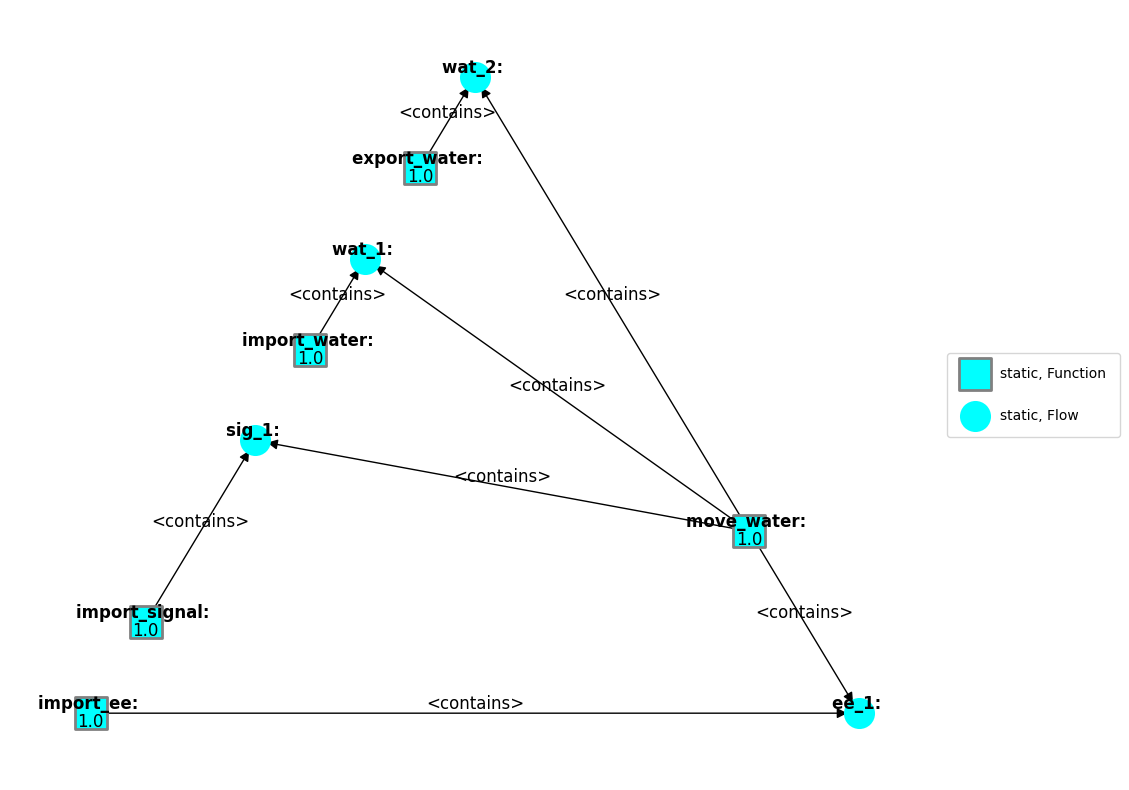

In [8]:
mg.draw()

As shown, because all of the methods were defined as generic behaviors, they are each run in the static propagation step. No order is shown in the static step because the static propagation step iterates between model functions until the values have converged. Nevertheless, one can view the initial static order using:

In [9]:
mdl.staticfxns

OrderedSet(['import_ee', 'import_water', 'import_signal', 'move_water', 'export_water'])

and the dynamic step order (if there was one):

In [10]:
mdl.dynamicfxns

OrderedSet()

We can also instantiate this model with different parameters. In Pump model, these are defined in `PumpParam`

In [11]:
from ex_pump import PumpParam
p = PumpParam()
p

PumpParam(cost=('repair', 'water'), delay=10)

We can pass non-default parameters to the model (as well as other non-defaults, such as simulation parameters `SimParam` and random seeds) by passing them as dictionaries. In this case:

In [12]:
mdl2 = Pump(p={'cost':('repair', 'water', 'ee'), 'delay':20})
mdl2

pump Pump
FUNCTIONS:
import_ee ImportEE
- ImportEEState(effstate=1.0)
- ImportEEMode(mode=nominal, faults=set())
import_water ImportWater
- ImportWaterMode(mode=nominal, faults=set())
import_signal ImportSig
- ImportSigMode(mode=nominal, faults=set())
move_water MoveWat
- MoveWatStates(eff=1.0)
- MoveWatMode(mode=nominal, faults=set())
export_water ExportWater
- ExportWaterMode(mode=nominal, faults=set())
FLOWS:
ee_1 Electricity flow: EEStates(current=1.0, voltage=1.0)
sig_1 Signal flow: SignalStates(power=1.0)
wat_1 Water flow: WaterStates(flowrate=1.0, pressure=1.0, area=1.0, level=1.0)
wat_2 Water flow: WaterStates(flowrate=1.0, pressure=1.0, area=1.0, level=1.0)

Note that, for a model:
- `p` is the `Parameter` defining non-mutable attributes (which do not change over a simulation)
- `sp` is the `SimParam` defining the simulation start, end, and end conditions
- `r` is the `Rand` defining random variables (e.g., for setting a seed)

## 2.), 3.), and 4.) Simulate and visualize the results!

Now, we will use the methods in `propagate` and the visualization modules in `rd` to simulate the model and visualize the results.

### 2a.) Simulate nominal

To simulate the model in the nominal scenario, use the `propagate.nominal` method, which returns:
endresults, which is a result (or a dict of multiple results) specified by the `desired_result` option, e.g.:
- 'endclass' (default), which provides the dict from `mdl.find_classification`
- 'graph' or `fmdtools.define.graph.Graph` subclass for the model.
- 'fxnname.varname'/'flowname.varname': which gets the values of these variables at a the end
- a list of the above arguments (to return a dict of multiple)
- a dict of lists (for multiple over time), e.g. `{time:[varnames,... 'endclass']}`

and mdlhist, which is a history of model states specified by the `track` option. Some of these options include:
- fxns'
- 'flows' 
- 'all'
- 'none'
- 'valparams' (model states specified in mdl.valparams), 
- or a dict of form: `{'functions':{'fxn1':'att1'}, 'flows':{'flow1':'att1'}}`

In [13]:
result_nominal, mdlhist_nominal=propagate.nominal(Pump(track="all"), desired_result="endclass")

What do the results look like? Explore results structures using the `desired_results` and `track` arguments.

In [14]:
result_nominal

endclass: 
--rate:                              1.0
--cost:                              0.0
--expected_cost:                     0.0

Note that an `endclass` dictionary can take arbitrary form based on what is produced in `find_classification`. By default, we often return:
- `rate`, which is the rate for the scenario calculated from the underlying fault probability model (defined in the `Mode` for each `Function`), 
- `cost`, which is some cost calculated based on the consequences of the scenario
- `expected_cost`, which is the expected value of the cost of the scenario (i.e. `rate*cost`).

In [15]:
mdlhist_nominal

i.finished:                    array(56)
i.on:                          array(56)
flows.ee_1.s.current:          array(56)
flows.ee_1.s.voltage:          array(56)
flows.sig_1.s.power:           array(56)
flows.wat_1.s.flowrate:        array(56)
flows.wat_1.s.pressure:        array(56)
flows.wat_1.s.area:            array(56)
flows.wat_1.s.level:           array(56)
flows.wat_2.s.flowrate:        array(56)
flows.wat_2.s.pressure:        array(56)
flows.wat_2.s.area:            array(56)
flows.wat_2.s.level:           array(56)
fxns.import_ee.s.effstate:     array(56)
fxns.import_ee.m.faults.no_v:  array(56)
fxns.import_ee.m.faults.inf_v: array(56)
fxns.import_water.m.faults.no_wat: array(56)
fxns.import_water.m.faults.less_wat: array(56)
fxns.import_signal.m.faults.no_sig: array(56)
fxns.move_water.i.over_pressure: array(56)
fxns.move_water.s.eff:         array(56)
fxns.move_water.m.faults.mech_break: array(56)
fxns.move_water.m.faults.short: array(56)
fxns.move_water.t.pressure_limit.

### 2b.) Visualize nominal model
First, we can show the model graph using `Graph.draw` to see that it was set up correctly. We can do this both on the model graph itself (using `ModelGraph`) and the results of the nominal run (by passing `graph` as an argument in `desired_result`) to verify both are fault-free.

Note that the underlyign `Graph` class is very flexible and enables a wide range of display options: 
- [Graph docs](https://nasa.github.io/fmdtools/docs/fmdtools.analyze.html#fmdtools.analyze.graph.Graph)
- [Graph.draw](https://nasa.github.io/fmdtools/docs/fmdtools.analyze.html#fmdtools.analyze.graph.Graph.draw)

(<Figure size 1200x1000 with 1 Axes>, <Axes: >)

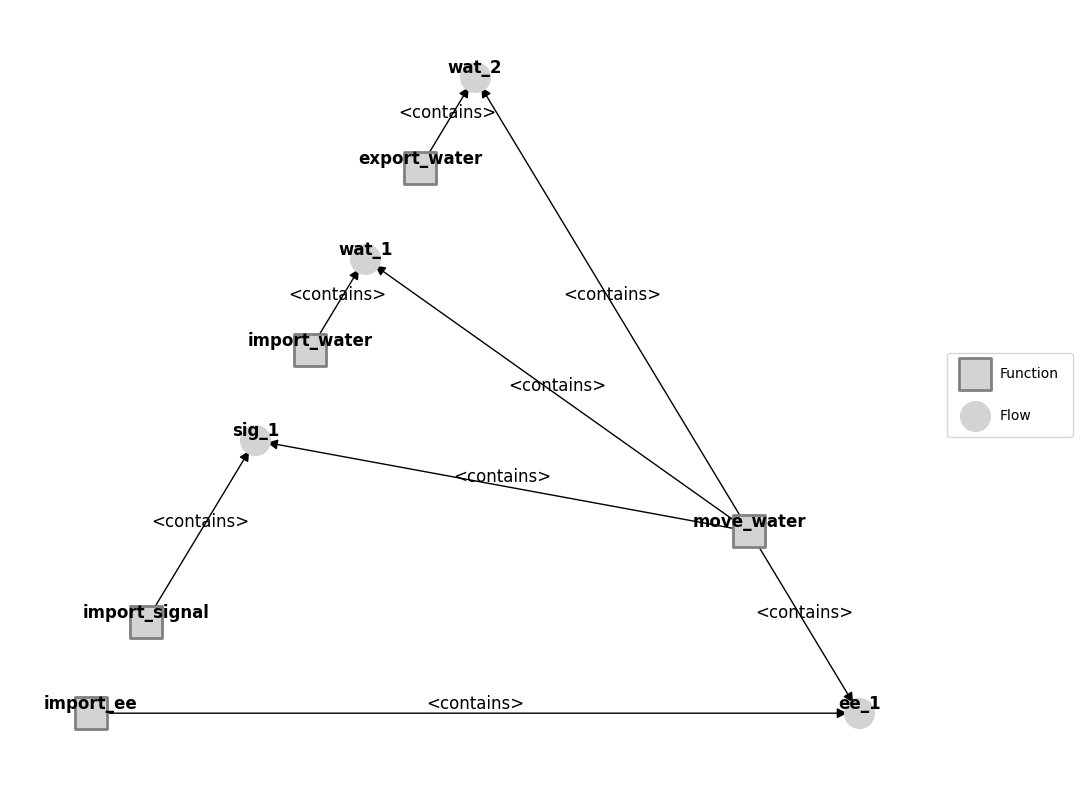

In [16]:
mg = an.graph.FunctionArchitectureGraph(mdl)
mg.draw()

We can also view the flow values of the model using `History.plot_line`


It may be helpful to only view flows of interest.

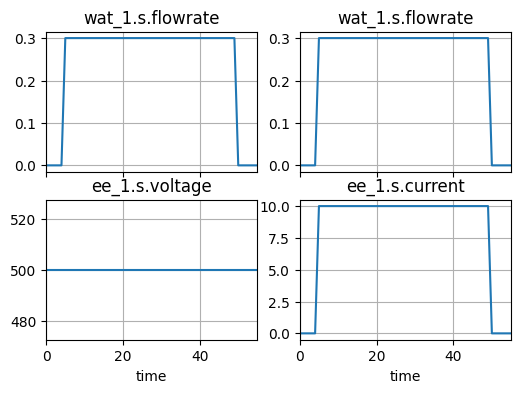

In [17]:
fig = mdlhist_nominal.plot_line('flows.wat_1.s.flowrate', 'flows.wat_1.s.flowrate',
                                'flows.ee_1.s.voltage', 'flows.ee_1.s.current')

Note: for quick access to the syntax and options for these methods, type the `?method` or `help(method)` in the terminal. For example `?History.plot_line`

### 2b.) Simulate a fault mode
To simulate the model in a fault scenario, use the `propagate.one_fault` method. The set of possible faults is defined in the function definitions in `ex_pump.py`, and we can propagate a fault at any time in the operational interval (0-55 seconds).

For example, below we simulate a short in the `MoveWater` function at time t=10:

In [18]:
results_fault, mdlhist_fault=propagate.one_fault(mdl, 'move_water', 'short', time=10, 
                                                 desired_result=['endclass', 'graph'], track="all")

We can also view the results for from this. In this case `mdlhist` gives a history of results for both the nominal and faulty runs.

In [19]:
results_fault

endclass.rate:                     1e-05
endclass.cost:        29000.000000000007
endclass.expected_cost: 29000.000000000007
graph: <fmdtools.analyze.graph.FunctionArchitectureGraph object at 0x000001832B64A5C0>

In [20]:
mdlhist_fault

nominal.i.finished:            array(56)
nominal.i.on:                  array(56)
nominal.flows.ee_1.s.current:  array(56)
nominal.flows.wat_2.s.flowrate: array(56)
nominal.time:                  array(56)
faulty.i.finished:             array(56)
faulty.i.on:                   array(56)
faulty.flows.ee_1.s.current:   array(56)
faulty.flows.wat_2.s.flowrate: array(56)
faulty.time:                   array(56)

### 3b.) Visualize fault model states
`History.plot_line` also works for a mdlhists given from `propagate.one_fault`. We can view these results below. As shown, the function will give the nominal result in a blue dotted line and the faulty result in a red line.

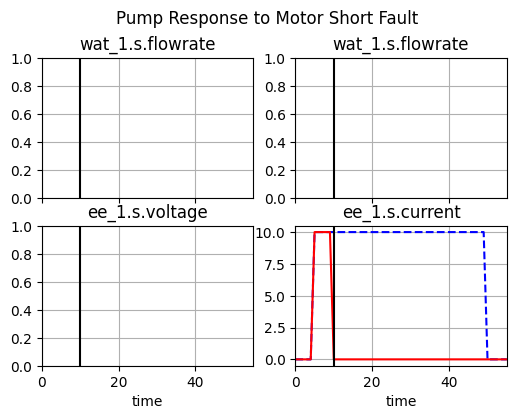

In [21]:
fig, axs = mdlhist_fault.plot_line('flows.wat_1.s.flowrate', 'flows.wat_1.s.flowrate',
                                    'flows.ee_1.s.voltage', 'flows.ee_1.s.current'
                                    title='Pump Response to Motor Short Fault', 
                                    time_slice=[10], legend_loc=False)

We can also view this result graph using `Graph.draw`. In this case, it shows the state of the model at the final time-step of the model run. Thus, while the `EE_1` flow is shown in orange (because it is off-nominal), the Water flows are not, because they have the same state at the final time-step.

(<Figure size 1200x1000 with 1 Axes>, <Axes: >)

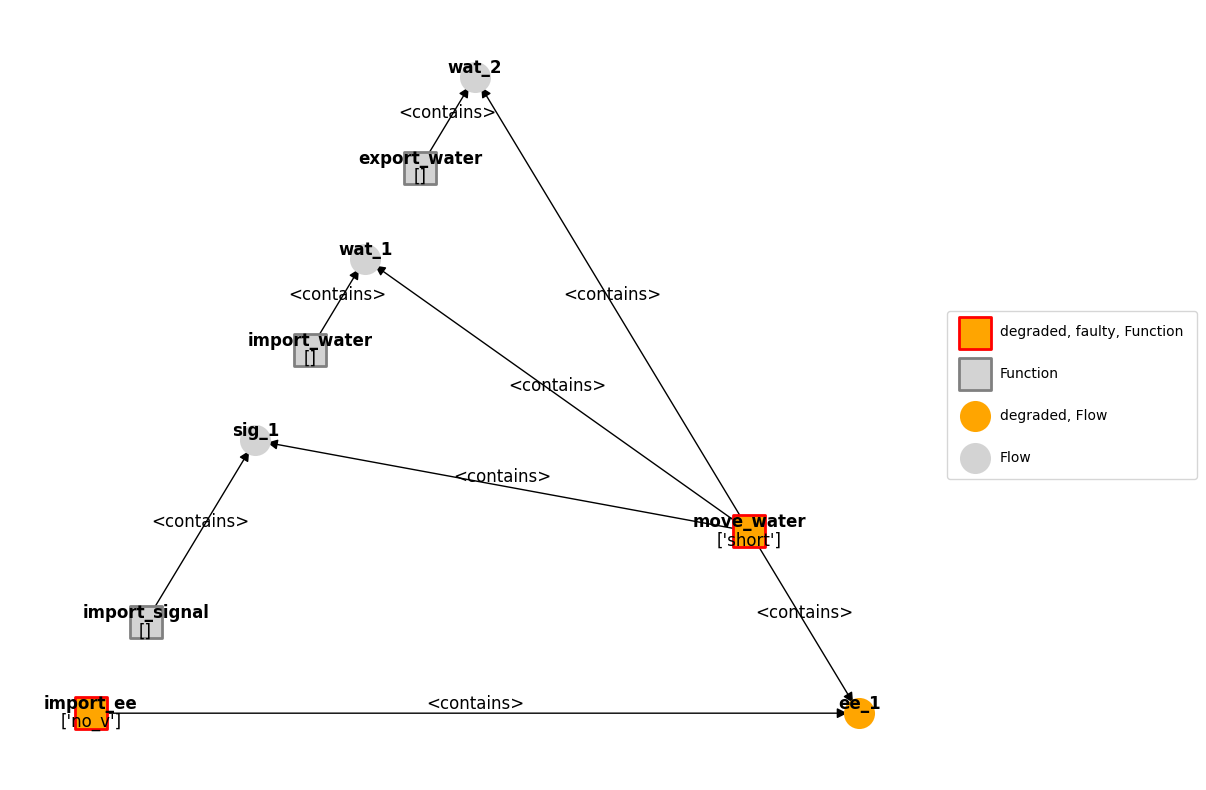

In [22]:
results_fault.graph.draw()

If we want to view the graph at another time-step, we can use `Graph.draw_from`, which will call `History.get_degraded_hist` to first process the model states into results which can be visualized and then map that onto a graph view at a given time.

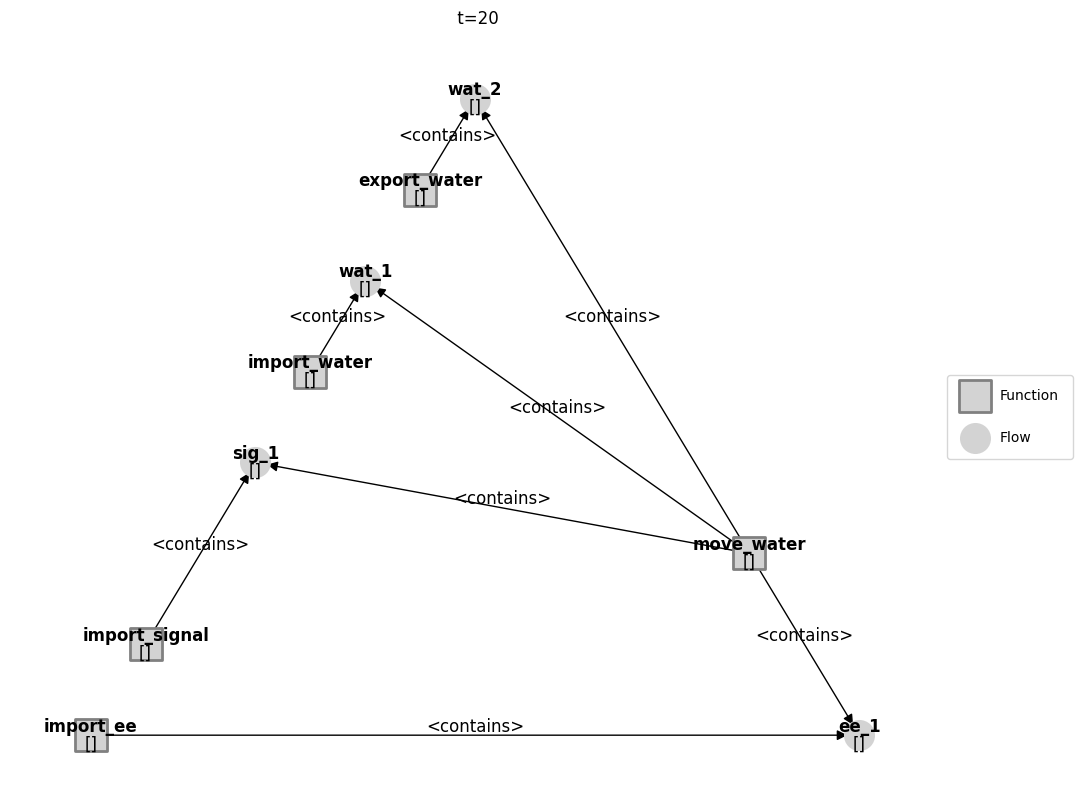

In [23]:
fig, ax = mg.draw_from(20,mdlhist_fault)

Note that multiple graph representations are available for the graph if desired...

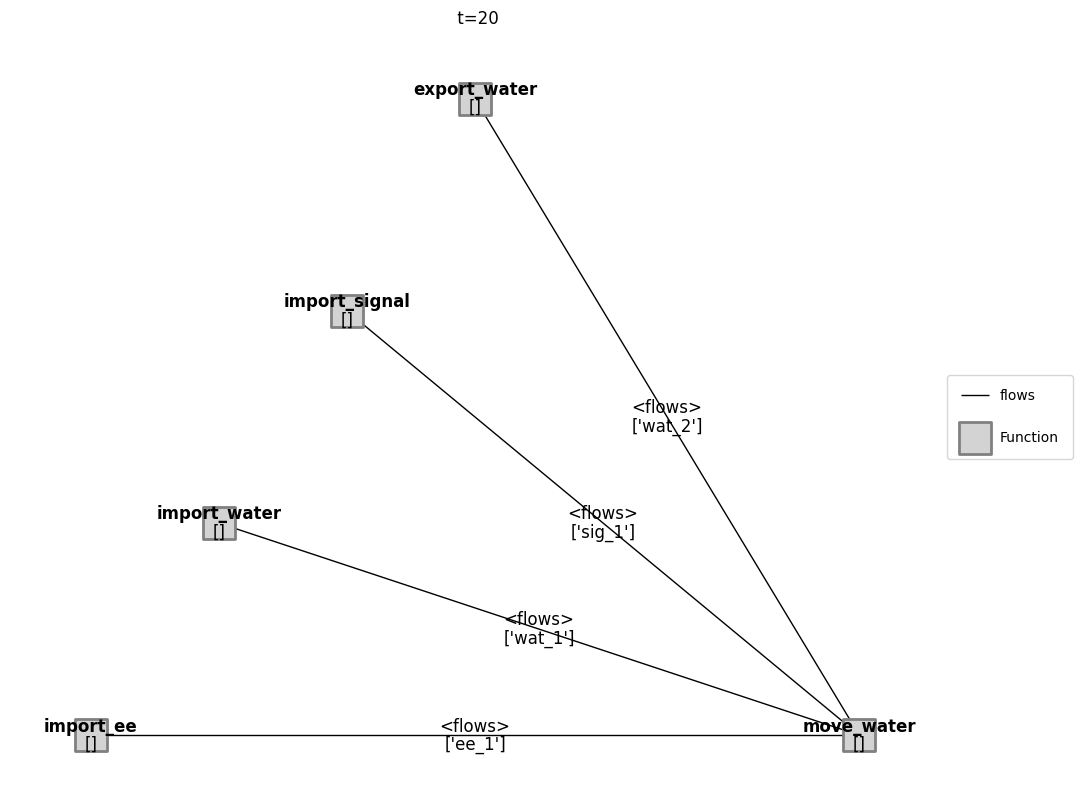

In [24]:
mg1 = an.graph.FunctionArchitectureFxnGraph(mdl)
fig, ax = mg1.draw_from(20,mdlhist_fault)

### 4a.) Simulate set of fault modes

To simulate the set of fault modes, we first choose a `FaultDomain` and `FaultSample`. For simplicity, we can choose default parameters at first.

In [25]:
fd = FaultDomain(mdl)
fd.add_all()
fd

FaultDomain with faults:
 -('import_ee', 'no_v')
 -('import_ee', 'inf_v')
 -('import_water', 'no_wat')
 -('import_water', 'less_wat')
 -('import_signal', 'no_sig')
 -('move_water', 'mech_break')
 -('move_water', 'short')
 -('export_water', 'block')

In [26]:
fs = FaultSample(fd, phasemap = PhaseMap(mdl.sp.phases))
fs.add_fault_phases()
fs

FaultSample of scenarios: 
 - import_ee_no_v_t2p0
 - import_ee_inf_v_t2p0
 - import_water_no_wat_t2p0
 - import_water_less_wat_t2p0
 - import_signal_no_sig_t2p0
 - move_water_mech_break_t2p0
 - move_water_short_t2p0
 - export_water_block_t2p0
 - import_ee_no_v_t27p0
 - import_ee_inf_v_t27p0
 - ... (24 total)

In [27]:
endclasses_samp, mdlhists_samp = propagate.fault_sample(mdl, fs)


SCENARIOS COMPLETE:   0%|          | 0/24 [00:00<?, ?it/s]


SCENARIOS COMPLETE:  21%|██        | 5/24 [00:00<00:00, 43.48it/s]


SCENARIOS COMPLETE:  42%|████▏     | 10/24 [00:00<00:00, 42.97it/s]


SCENARIOS COMPLETE:  62%|██████▎   | 15/24 [00:00<00:00, 42.87it/s]


SCENARIOS COMPLETE:  83%|████████▎ | 20/24 [00:00<00:00, 42.10it/s]


SCENARIOS COMPLETE: 100%|██████████| 24/24 [00:00<00:00, 42.46it/s]

It can be helpful to view what these results look like--a `Result` of faults injected at particular times with their correspnding `Result` dictionaries.

In [28]:
endclasses_samp

import_ee_no_v_t2p0.endclass.rate:   0.0
import_ee_no_v_t2p0.endclass.cost: 20125.000000000007
import_ee_no_v_t2p0.                 0.0
import_ee_inf_v_t2p0.endclass.rate:  0.0
import_ee_inf_v_t2p0.endclass.cost: 25125.000000000007
import_ee_inf_v_t2p0                 0.0
import_water_no_wat_t2p0.endclass.rate: 1e-05
import_water_no_wat_t2p0.endclass.cost: 11125.000000000007
import_water_no_wat_  11125.000000000007
import_water_less_wa               1e-05
import_water_less_wa   5062.500000000004
import_water_less_wa   5062.500000000004
import_signal_no_sig             1.5e-06
import_signal_no_sig  20125.000000000007
import_signal_no_sig   3018.750000000001
move_water_mech_brea6.000000000000001e-07
move_water_mech_brea  15125.000000000007
move_water_mech_brea   907.5000000000005
move_water_short_t2p0.endclass.rate: 1.5000000000000002e-05
move_water_short_t2p0.endclass.cost: 30125.000000000007
move_water_short_t2p  45187.500000000015
export_water_block_t2p0.endclass.rate: 1.5000000000000

We can look at/use a more structured version using:

In [29]:
ec_nest = endclasses_samp.nest()
ec_nest

import_ee_inf_v_t27p0: 
--endclass: 
----rate:         2.0000000000000003e-06
----cost:                        20175.0
----expected_cost:     4035.000000000001
export_water_block_t27p0: 
--endclass: 
----rate:                          1e-05
----cost:                        15152.5
----expected_cost:               15152.5
export_water_block_t52p0: 
--endclass: 
----rate:                          1e-05
----cost:                         5000.0
----expected_cost:                5000.0
import_signal_no_sig_t2p0: 
--endclass: 
----rate:                        1.5e-06
----cost:             20125.000000000007
----expected_cost:     3018.750000000001
import_ee_no_v_t52p0: 
--endclass: 
----rate:                            0.0
----cost:                        10000.0
----expected_cost:                   0.0
import_water_no_wat_t2p0: 
--endclass: 
----rate:                          1e-05
----cost:             11125.000000000007
----expected_cost:    11125.000000000007
move_water_short_t27p0: 
--e

We often want to adjust the `FaultDomain` and `SampleApproach` to answer specific questions about the model (e.g. focussing on single faults, different numbers of sample points, etc). Both have different methods with options which can be changed to enable this, e.g.:

In [30]:
fd2 = FaultDomain(mdl)
fd2.add_fault('move_water', 'short')
fd2

FaultDomain with faults:
 -('move_water', 'short')

In [31]:
fs2 = FaultSample(fd2, phasemap = PhaseMap(mdl.sp.phases))
fs2.add_fault_phases(args=(4,))
fs2

FaultSample of scenarios: 
 - move_water_short_t0p0
 - move_water_short_t1p0
 - move_water_short_t2p0
 - move_water_short_t3p0
 - move_water_short_t4p0
 - move_water_short_t14p0
 - move_water_short_t23p0
 - move_water_short_t31p0
 - move_water_short_t40p0
 - move_water_short_t51p0
 - ... (13 total)

There are a number of different ways to sample the scenarios in the approach:

In [32]:
fs2.times

<bound method FaultSample.times of FaultSample of scenarios: 
 - move_water_short_t0p0
 - move_water_short_t1p0
 - move_water_short_t2p0
 - move_water_short_t3p0
 - move_water_short_t4p0
 - move_water_short_t14p0
 - move_water_short_t23p0
 - move_water_short_t31p0
 - move_water_short_t40p0
 - move_water_short_t51p0
 - ... (13 total)>

### 4b.) Visualize set of fault modes

Using this fault approach, we can now make an FMEA-like analyses of the different fault modes. The `an.tabulate.FMEA` class organizes endclasses such that you can create a table (or plot) for each fault.

In [33]:
summary_fmea = an.tabulate.FMEA(endclasses_samp, fs)
summary_fmea.as_table()

,,rate,cost,expected_cost
move_water,short,0.000035,24277.083333,0.803625
export_water,block,0.000035,15093.541667,0.503063
import_water,no_wat,0.000030,6100.000000,0.183000
import_ee,no_v,0.000008,9573.333333,0.121400
move_water,mech_break,0.000008,6472.250000,0.085335
import_water,less_wat,0.000030,2550.000000,0.076500
import_signal,no_sig,0.000003,8472.708333,0.055363
import_ee,inf_v,0.000002,9055.833333,0.040350


We can also use `an.tabulate.result_summary_fmea` with the processed results histories to get a better picture of which flows and functions degrade in each scenario. 

In [34]:
an.tabulate.result_summary_fmea(endclasses_samp, mdlhists_samp, *mdl.fxns, *mdl.flows)

,degraded,faulty,rate,cost,expected_cost
import_ee_inf_v_t27p0,"['ee_1', 'wat_2']",[],0.000002,20175.0,4035.0
export_water_block_t27p0,"['ee_1', 'wat_2']",[],0.00001,15152.5,15152.5
export_water_block_t52p0,"['ee_1', 'wat_2']",[],0.00001,5000.0,5000.0
import_signal_no_sig_t2p0,"['ee_1', 'wat_2']",[],0.000002,20125.0,3018.75
import_ee_no_v_t52p0,"['ee_1', 'wat_2']",[],0.0,10000.0,0.0
import_water_no_wat_t2p0,"['ee_1', 'wat_2']",[],0.00001,11125.0,11125.0
move_water_short_t27p0,"['ee_1', 'wat_2']",[],0.00001,25175.0,25175.0
import_signal_no_sig_t27p0,"['ee_1', 'wat_2']",[],0.000001,15175.0,1517.5
export_water_block_t2p0,"['ee_1', 'wat_2']",[],0.000015,20102.5,30153.75
import_ee_inf_v_t52p0,"['ee_1', 'wat_2']",[],0.0,5000.0,0.0


**Note that this is contingent on what we tracked in the history!** In the above model, we used the default, which is only a few variables defined in the model. 

If we tracked all, on the other hand, we would get the result below:

In [35]:
endclasses_samp, mdlhists_samp = propagate.fault_sample(mdl, fs, track="all")
an.tabulate.result_summary_fmea(endclasses_samp, mdlhists_samp, *mdl.fxns, *mdl.flows)


SCENARIOS COMPLETE:   0%|          | 0/24 [00:00<?, ?it/s]


SCENARIOS COMPLETE:  21%|██        | 5/24 [00:00<00:00, 43.10it/s]


SCENARIOS COMPLETE:  42%|████▏     | 10/24 [00:00<00:00, 42.49it/s]


SCENARIOS COMPLETE:  62%|██████▎   | 15/24 [00:00<00:00, 42.77it/s]


SCENARIOS COMPLETE:  83%|████████▎ | 20/24 [00:00<00:00, 43.19it/s]


SCENARIOS COMPLETE: 100%|██████████| 24/24 [00:00<00:00, 42.79it/s]

,degraded,faulty,rate,cost,expected_cost
import_ee_inf_v_t27p0,"['ee_1', 'wat_2']",[],0.000002,20175.0,4035.0
export_water_block_t27p0,"['ee_1', 'wat_2']",[],0.00001,15152.5,15152.5
export_water_block_t52p0,"['ee_1', 'wat_2']",[],0.00001,5000.0,5000.0
import_signal_no_sig_t2p0,"['ee_1', 'wat_2']",[],0.000002,20125.0,3018.75
import_ee_no_v_t52p0,"['ee_1', 'wat_2']",[],0.0,10000.0,0.0
import_water_no_wat_t2p0,"['ee_1', 'wat_2']",[],0.00001,11125.0,11125.0
move_water_short_t27p0,"['ee_1', 'wat_2']",[],0.00001,25175.0,25175.0
import_signal_no_sig_t27p0,"['ee_1', 'wat_2']",[],0.000001,15175.0,1517.5
export_water_block_t2p0,"['ee_1', 'wat_2']",[],0.000015,20102.5,30153.75
import_ee_inf_v_t52p0,"['ee_1', 'wat_2']",[],0.0,5000.0,0.0


## 5.) Saving Work

In computationally expensive simulations, running a lot of computational simulations can take a considerable amount of time. As a result, it becomes impractical to run a new simulation every time one wishes to analyse its data. Results from fmdtools simulations (endclasses or mdlhists) can be saved as pickle, csv, or json files in this instance using either:
- `Result.save`/`History.save` or 
- passing a save_args dictionary to the respective propagate functions (e.g., `{'endclass':{'filename':'file.pkl','overwrite':True}`)

and then loaded using:
- `Result.load`/`History.load`

For example, for this variable:

In [36]:
endclasses_samp

import_ee_no_v_t2p0.endclass.rate:   0.0
import_ee_no_v_t2p0.endclass.cost: 20125.000000000007
import_ee_no_v_t2p0.                 0.0
import_ee_inf_v_t2p0.endclass.rate:  0.0
import_ee_inf_v_t2p0.endclass.cost: 25125.000000000007
import_ee_inf_v_t2p0                 0.0
import_water_no_wat_t2p0.endclass.rate: 1e-05
import_water_no_wat_t2p0.endclass.cost: 11125.000000000007
import_water_no_wat_  11125.000000000007
import_water_less_wa               1e-05
import_water_less_wa   5062.500000000004
import_water_less_wa   5062.500000000004
import_signal_no_sig             1.5e-06
import_signal_no_sig  20125.000000000007
import_signal_no_sig   3018.750000000001
move_water_mech_brea6.000000000000001e-07
move_water_mech_brea  15125.000000000007
move_water_mech_brea   907.5000000000005
move_water_short_t2p0.endclass.rate: 1.5000000000000002e-05
move_water_short_t2p0.endclass.cost: 30125.000000000007
move_water_short_t2p  45187.500000000015
export_water_block_t2p0.endclass.rate: 1.5000000000000

In [37]:
endclasses_samp.save('tutorial_endclasses.csv', overwrite=True)

File already exists: tutorial_endclasses.csv, writing anyway...


In [38]:
endclasses_saved = an.result.Result.load('tutorial_endclasses.csv')

In [39]:
endclasses_saved

import_ee_no_v_t2p0.endclass.rate:   0.0
import_ee_no_v_t2p0.endclass.cost: 20125.000000000007
import_ee_no_v_t2p0.                 0.0
import_ee_inf_v_t2p0.endclass.rate:  0.0
import_ee_inf_v_t2p0.endclass.cost: 25125.000000000007
import_ee_inf_v_t2p0                 0.0
import_water_no_wat_t2p0.endclass.rate: 1e-05
import_water_no_wat_t2p0.endclass.cost: 11125.000000000007
import_water_no_wat_  11125.000000000007
import_water_less_wa               1e-05
import_water_less_wa   5062.500000000004
import_water_less_wa   5062.500000000004
import_signal_no_sig             1.5e-06
import_signal_no_sig  20125.000000000007
import_signal_no_sig   3018.750000000001
move_water_mech_brea6.000000000000001e-07
move_water_mech_brea  15125.000000000007
move_water_mech_brea   907.5000000000005
move_water_short_t2p0.endclass.rate: 1.5000000000000002e-05
move_water_short_t2p0.endclass.cost: 30125.000000000007
move_water_short_t2p  45187.500000000015
export_water_block_t2p0.endclass.rate: 1.5000000000000